In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_path = os.environ['HOME'] + '/cifar10/simpleCNN'
if os.path.isdir(base_path):
  pass
else:
  os.makedirs(base_path)

In [3]:
writer = SummaryWriter(base_path + '/runs/simpleCNN')

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=base_path + '/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root=base_path + '/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
  img = img/2+0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show
  
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

  dog   dog   car  frog


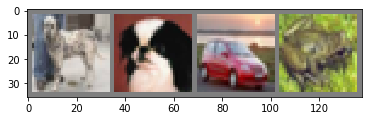

In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
writer.add_image("Four cifar-10 images", img_grid)

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x #logit
    
net = Net()

In [9]:
writer.add_graph(net, images)
writer.close()

In [10]:
hypothesis = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [11]:
def images_to_probs(net, images):
  output = net(images)
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy())
  return preds, [F.softmax(el, dim=0)[0].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
  preds, probs = images_to_probs(net, images)
  fig = plt.figure(figsize=(12, 48))
  for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    matplotlib_imshow(images[idx])
    ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
    classes[preds[idx]],
    probs[idx] * 100.0,
    classes[labels[idx]]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
  return fig

In [13]:
for epoch in range(10):
  running_loss = 0.0
  
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = hypothesis(outputs, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 1000 == 999:
      print("[{}, {}] loss:{}".format(epoch+1, i+1, running_loss/2000))
      writer.add_scalar(
        'training loss',
        running_loss/1000,
        epoch*len(trainloader)+i)
      writer.add_figure(
        'predictions vs. actuals',
        plot_classes_preds(net, inputs, labels),
        global_step=epoch*len(trainloader)+i)
      
      running_loss = 0.0
print('Finished Training')

NameError: name 'optimizer' is not defined

In [13]:
PATH = base_path + '/simpleCNN.pt'
torch.save(net, PATH)

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Ground truth: ['cat', 'ship', 'ship', 'plane']


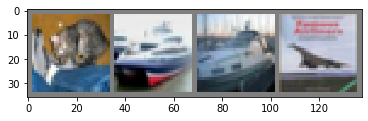

In [14]:
test_dataiter = iter(testloader)
images, labels = test_dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Ground truth: {}'.format([classes[label] for label in labels]))

In [15]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: {}'.format([classes[label] for label in predicted]))

Predicted: ['cat', 'car', 'ship', 'ship']


In [16]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy:{}%'.format(100*correct/total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy:62.35%
Accuracy of plane : 56 %
Accuracy of   car : 73 %
Accuracy of  bird : 49 %
Accuracy of   cat : 35 %
Accuracy of  deer : 56 %
Accuracy of   dog : 64 %
Accuracy of  frog : 71 %
Accuracy of horse : 68 %
Accuracy of  ship : 75 %
Accuracy of truck : 72 %


tensor([3, 1, 8, 8])  tensor([3, 8, 8, 0])


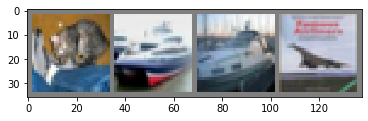

In [17]:
PATH = base_path + '/simpleCNN.pt'
the_model = torch.load(PATH)

images, labels = next(iter(testloader))
_, predicted = torch.max(the_model(images), 1)
print(predicted, "\b", labels)
imshow(torchvision.utils.make_grid(images))